In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


Device: cpu


# Your Average Sentiment Network (AvgNet)

### Data Pre-processing and Preparation

This paper [1,4] calculates the n-grams of an input sentence and append them to the end of a sentence. Here, we'll use bi-grams. Briefly, a bi-gram is a pair of words/tokens that appear consecutively within a sentence.

For example, in the sentence "how are you ?", the bi-grams are: "how are", "are you" and "you ?".

The generate_bigrams function takes a sentence that has already been tokenized, calculates the bi-grams and appends them to the end of the tokenized list.

In [ ]:
def generate_bigrams(x):
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    return x

As an example:


In [ ]:
generate_bigrams(['This', 'film', 'is', 'terrible'])

['This', 'film', 'is', 'terrible', 'film is', 'is terrible', 'This film']

TorchText Fields have a preprocessing argument. A function passed here will be applied to a sentence after it has been tokenized (transformed from a string into a list of tokens), but before it has been numericalized (transformed from a list of tokens to a list of indexes). This is where we'll pass our generate_bigrams function.

As we aren't using an RNN we can't use packed padded sequences, thus we do not need to set include_lengths = True.

In [ ]:
# Processing pipelines
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1.0 if x == 'pos' else 0.0

# Example of pipelines in action
# print(text_pipeline('this film is great'))
# print(label_pipeline('pos'))

In [ ]:
# Processing pipelines
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1.0 if x == 'pos' else 0.0

# Example of pipelines in action
# print(text_pipeline('this film is great'))
# print(label_pipeline('pos'))

In [ ]:
!pip3 install torch torchvision torchaudio torchtext --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.4/780.4 MB ? eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB ? eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.4 MB/s

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 101.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import torch
from torchtext import data
from torchtext import datasets

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language='en_core_web_sm',
                  preprocessing = generate_bigrams)

LABEL = data.LabelField(dtype = torch.float)

As before, we load the IMDb dataset and create the splits.

In [ ]:
class IMDB(data.Dataset):
    """
    Modified class to load the IMDB dataset directly from a local path,
    now including filenames.
    """
    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    def __init__(self, path, text_field, label_field, **kwargs):
        fname_field = data.RawField()
        fields = [('text', text_field), ('label', label_field), ('aname', fname_field)]
        examples = []

        for label in ['pos', 'neg']:
            for fname in glob.iglob(os.path.join(path, label, '*.txt')):
                with io.open(fname, 'r', encoding="utf-8") as f:
                    text = f.read()
                    # Create a cleaner filename (e.g., "pos/123_10.txt")
                    clean_fname = os.path.join(label, os.path.basename(fname))
                    # Add the filename to the data example
                    examples.append(data.Example.fromlist(
                        [text, label, clean_fname], fields))

        super(IMDB, self).__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, text_field, label_field, root_dir=None,
               train='train', test='test', **kwargs):
        """
        This method now constructs the paths and directly
        creates the Dataset objects, bypassing the downloader.
        """
        # Define the base path to your dataset in Google Drive
        base_path = '/content/drive/MyDrive/Sentiment-Analysis/aclIMDB/aclImdb'

        # Create the full paths for train and test directories
        train_path = os.path.join(base_path, train)
        test_path = os.path.join(base_path, test)

        # Directly create train and test datasets using our __init__ method
        train_data = cls(train_path, text_field, label_field, **kwargs)
        test_data = cls(test_path, text_field, label_field, **kwargs)

        return train_data, test_data

train_data, test_data = IMDB.splits(TEXT, LABEL)

print(f"Length of training data: {len(train_data)}")
print(f"Length of test data: {len(test_data)}")

if len(test_data) > 0:
    print(f"Example filename from test set: {test_data.examples[0].aname}")


random.seed(SEED)

train_data, valid_data = train_data.split()

print(f"Length after split: Train={len(train_data)}, Valid={len(valid_data)}")

Length of training data: 15327
Length of test data: 25000
Example filename from test set: pos/9100_10.txt
Length after split: Train=10729, Valid=4598


Build the vocab and load the pre-trained word embeddings.

In [ ]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data,
                 max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device)

/usr/local/lib/python3.12/dist-packages/torchtext/vocab.py:432: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.itos, self.stoi, self.vectors, self.dim = torch.load(path_

And create the iterators.

# Designing the deep NLP Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NLPModel1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):

        #text = [sent len, batch size]

        embedded = self.embedding(text)

        #embedded = [sent len, batch size, emb dim]

        embedded = embedded.permute(1, 0, 2)

        #embedded = [batch size, sent len, emb dim]

        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1)

        #pooled = [batch size, embedding_dim]

        return self.fc(pooled)

Next, we make the instance of our NLPModel1 class.

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = NLPModel1(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)

Looking at the number of parameters in our model:

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('The model has ',str(count_parameters(model)),'trainable parameters')

The model has  2500301 trainable parameters


And copy the pre-trained vectors to our embedding layer.

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-1.2241, -0.2798,  1.0831,  ..., -2.1036, -2.7767, -1.0856],
        [ 1.0195,  1.7941, -0.5507,  ..., -0.1300, -0.5501,  1.1823],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 1.6246, -0.7330, -0.4125,  ..., -0.8146, -0.7123,  0.5247],
        [ 0.1171,  0.6961,  0.0925,  ...,  0.7209, -1.8777, -0.7577],
        [-0.1551,  0.1054, -2.9147,  ..., -0.4359, -0.2221,  1.2497]])

Not forgetting to zero the initial weights of our unknown and padding tokens.

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# NLP Model Training Process

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

We define the criterion and place the model and criterion on the GPU (if available)...

In [ ]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

We implement the function to calculate accuracy...

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

We define a function for training our model...

In [ ]:
train_loss_values=[]
valid_loss_values=[]

train_acc_values=[]
valid_acc_values=[]

def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    #batch = next(iterator.__iter__())
    #print(batch.text)
    #print(batch.aname)
    #print(batch.text)
    #usman: check eval

    for batch in iterator:

        optimizer.zero_grad()

        predictions = model(batch.text).squeeze(1)

        loss = criterion(predictions, batch.label)

        acc = binary_accuracy(predictions, batch.label)

        loss.backward()

        optimizer.step()

#        train_loss_values.append(loss.item())

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We define a function for testing our model...

In [ ]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    #sssssssss
    with torch.no_grad():

        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            #print(predictions)
            #print(batch.text.shape)
            #print(TEXT.vocab.itos[11])
            #sssdsdssd
            loss = criterion(predictions, batch.label)

            acc = binary_accuracy(predictions, batch.label)

            #valid_loss_values.append(loss.item())

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

from sklearn.metrics import precision_score,recall_score
precision=[]

def evaluate_test(model, iterator, criterion):


    import csv

    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_recall = 0

    g=0
    model.eval()
    #sssssssss
    with torch.no_grad():

        for batch in iterator:
            g=g+1
            predictions = model(batch.text).squeeze(1)
            rounded_preds_us = torch.round(torch.sigmoid(predictions))

            epoch_prec+=precision_score(batch.label, rounded_preds_us, average='weighted')
            epoch_recall+=recall_score(batch.label, rounded_preds_us, average='weighted')

            #precision_score(y_true, y_pred, average='micro')

            #precision_score(y_true, y_pred, average='weighted')

            #print(predictions)
            #print(batch.text.shape)
            #print(TEXT.vocab.itos[11])

            loss = criterion(predictions, batch.label)

            acc = binary_accuracy(predictions, batch.label)
            #print(epoch_prec)
            #print(rounded_preds_us)
            #usman:check valid later

            with open('sentiment_results_model1_reviews.csv', mode='a') as sent_file:
                file_writer = csv.writer(sent_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

                for x in range(0,len(predictions)):
                    file_writer.writerow([batch.aname[x], rounded_preds_us[x].item(),batch.label[x].item()])


            epoch_loss += loss.item()
            epoch_acc += acc.item()
    #print('g=',str(g))
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_prec / len(iterator), epoch_recall / len(iterator)

As before, we'll implement a useful function to tell us how long an epoch takes.

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model.

In [ ]:
N_EPOCHS = 50

train_loss_values=[]
valid_loss_values=[]

train_acc_values=[]
valid_acc_values=[]

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_loss_values.append(train_loss)
    valid_loss_values.append(valid_loss)

    train_acc_values.append(train_acc)
    valid_acc_values.append(valid_acc)


    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'Model1Reviews.pt')

    print('Epoch: ',str(epoch+1),' | Epoch Time:',str(epoch_mins),'m ',str(epoch_secs),'s')
    print('\tTrain Loss: ',str(train_loss),' | Train Acc: ',str(train_acc*100),'%')
    print('\t Val. Loss: ',str(valid_loss),' |  Val. Acc: ',str(valid_acc*100),'%')

Epoch:  1  | Epoch Time: 0 m  53 s
	Train Loss:  0.5719500845741659  | Train Acc:  81.49431074659029 %
	 Val. Loss:  0.6137911400033368  |  Val. Acc:  81.64785876870155 %
Epoch:  2  | Epoch Time: 0 m  55 s
	Train Loss:  0.5120861986208529  | Train Acc:  81.5203977837449 %
	 Val. Loss:  0.6988276429474354  |  Val. Acc:  81.64785876870155 %
Epoch:  3  | Epoch Time: 0 m  50 s
	Train Loss:  0.4955385502960001  | Train Acc:  81.5203977837449 %
	 Val. Loss:  0.683998201870256  |  Val. Acc:  81.64785876870155 %
Epoch:  4  | Epoch Time: 0 m  49 s
	Train Loss:  0.4768327691015743  | Train Acc:  81.5203977837449 %
	 Val. Loss:  0.592046062151591  |  Val. Acc:  81.64785876870155 %
Epoch:  5  | Epoch Time: 0 m  46 s
	Train Loss:  0.4507438416282336  | Train Acc:  81.5203977837449 %
	 Val. Loss:  0.5511398514111837  |  Val. Acc:  81.73466432425711 %
Epoch:  6  | Epoch Time: 1 m  0 s
	Train Loss:  0.420125214826493  | Train Acc:  81.62157010464442 %
	 Val. Loss:  0.48816706612706184  |  Val. Acc:  8

In [ ]:
print(len(train_loss_values))
print(len(valid_loss_values))
print(train_loss_values)
print(valid_loss_values)

print(len(train_acc_values))
print(len(valid_acc_values))
print(train_acc_values)
print(valid_acc_values)

with open('the_model1_performance.txt', 'w') as filehandle:
    tLoss=','.join([str(x) for x in train_loss_values])
    filehandle.write(tLoss+"\n")
    tLoss=','.join([str(x) for x in valid_loss_values])
    filehandle.write(tLoss+"\n")
    tLoss=','.join([str(x) for x in train_acc_values])
    filehandle.write(tLoss+"\n")
    tLoss=','.join([str(x) for x in valid_acc_values])
    filehandle.write(tLoss)


    #for listitem in train_loss_values:
     #   filehandle.write(listitem)

50
50
[0.5719500845741659, 0.5120861986208529, 0.4955385502960001, 0.4768327691015743, 0.4507438416282336, 0.420125214826493, 0.39196064447363216, 0.36507736714113326, 0.33904166617209003, 0.3144098456416811, 0.28837099724582266, 0.2659609238838866, 0.2437762070801996, 0.22327938423092877, 0.20909426707242215, 0.19221958455940089, 0.17867690533222186, 0.1662411287072159, 0.155119931680106, 0.14491716696925105, 0.1338924416119144, 0.12555332020634696, 0.11766839983119141, 0.11007262506921377, 0.10206133252497585, 0.09618096705526114, 0.08913817464019216, 0.08388073086029008, 0.07931369588532973, 0.0742331861873113, 0.06916931167887967, 0.06341367387878043, 0.06028876412061176, 0.05689920521052998, 0.05172813085040876, 0.048608826307047694, 0.04539767075108275, 0.04213544218579218, 0.03895970340540987, 0.03707860134974388, 0.03506583129915054, 0.03180786869017452, 0.029315305336023726, 0.026983159082841927, 0.025407065575044335, 0.024295889941554162, 0.02156345560762843, 0.02024074937521

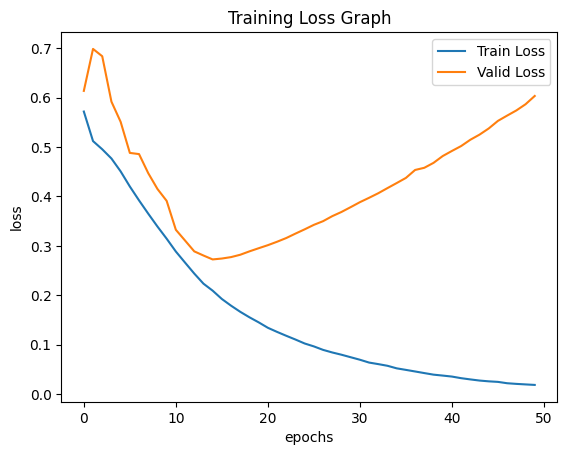

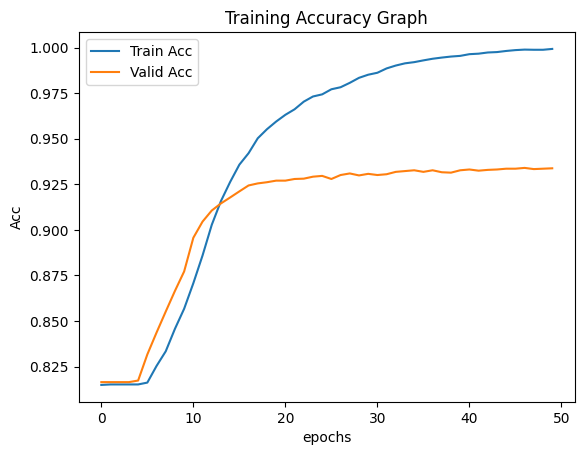

In [ ]:
from matplotlib import pyplot as plt


train_loss_values=[]
valid_loss_values=[]

train_acc_values=[]
valid_acc_values=[]


# open file and read the content in a list
with open('the_model1_performance.txt', 'r') as filehandle:
    filecontents = filehandle.readlines()

    train_loss_values=[float(i) for i in filecontents[0].split(',')]
    valid_loss_values=[float(i) for i in filecontents[1].split(',')]
    train_acc_values=[float(i) for i in filecontents[2].split(',')]
    valid_acc_values=[float(i) for i in filecontents[3].split(',')]

plt.title('Training Loss Graph')
plt.plot(train_loss_values,label='Train Loss')
plt.plot(valid_loss_values,label='Valid Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


plt.title('Training Accuracy Graph')
plt.plot(train_acc_values,label='Train Acc')
plt.plot(valid_acc_values,label='Valid Acc')
plt.xlabel('epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

...and get the test accuracy!

In [ ]:
model.load_state_dict(torch.load('Model1Reviews.pt'))

import csv

with open('sentiment_results_model1_reviews.csv', mode='w') as sent_file:
    file_writer = csv.writer(sent_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    file_writer.writerow(['Review File Path', 'Our Prediction', 'Ground Truth (1: pos, 0:neg)'])





test_loss, test_acc, test_prec, test_recall = evaluate_test(model, test_iterator, criterion)

print('Test Loss: ',str(test_loss),' | Acc:',str(test_acc*100),'% ', 'Precision: ',str(test_prec), 'Recall: ',str(test_recall))
print('Results are also written in the csv file')

/tmp/ipython-input-500325671.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Model1Reviews.pt'))


Test Loss:  0.704562324468437  | Acc: 80.08631713250104 %  Precision:  0.8429483999694547 Recall:  0.8008631713554987
Results are also written in the csv file


Now generating word cloud.

Index(['Review File Path', 'Our Prediction', 'Ground Truth (1: pos, 0:neg)'], dtype='object')


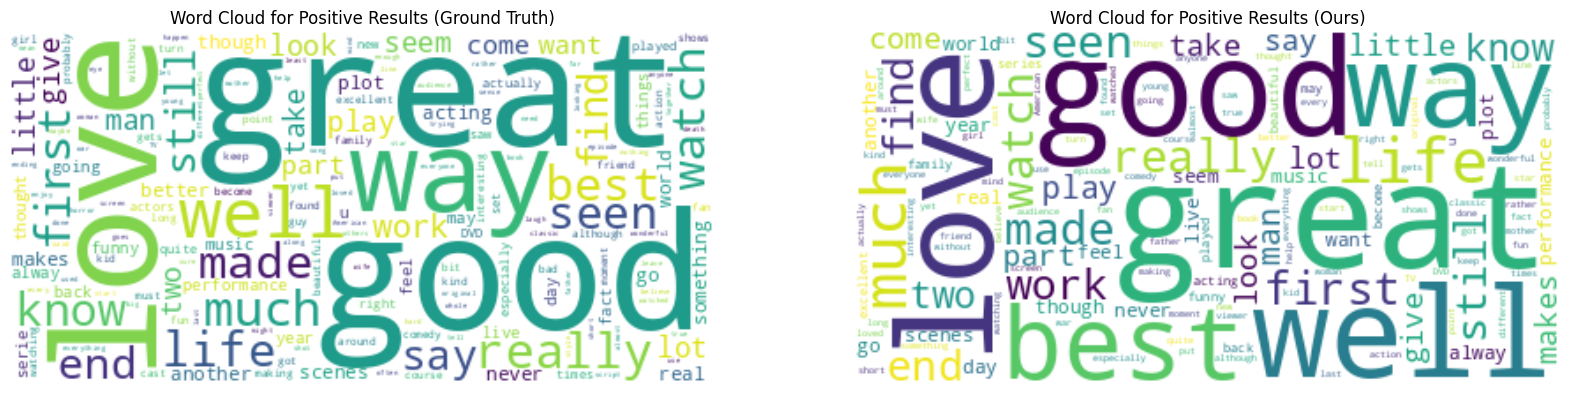

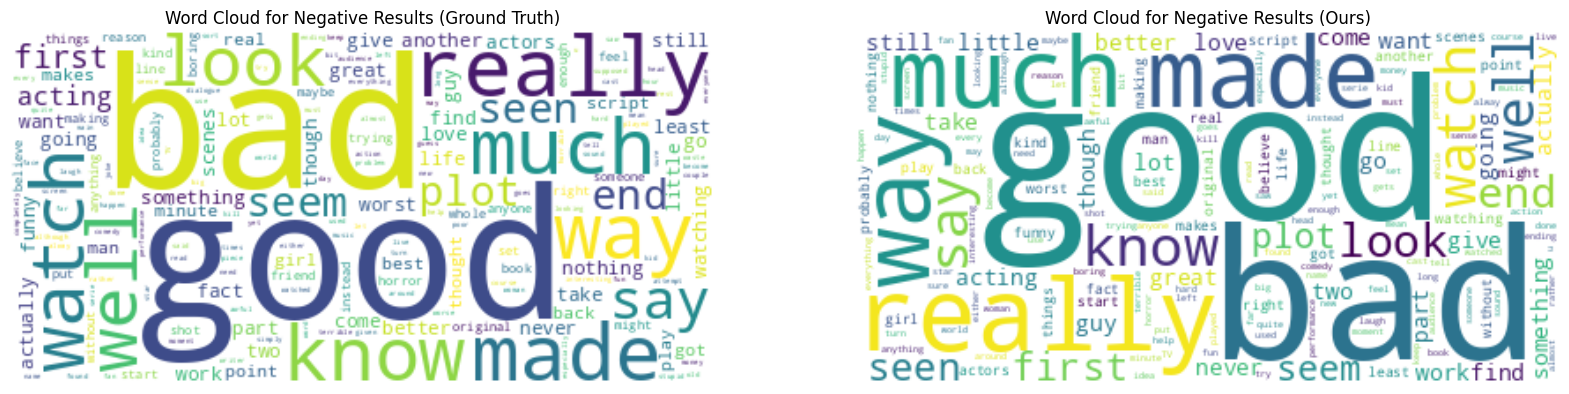

In [ ]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd

my_directory='/content/drive/MyDrive/Sentiment-Analysis/aclIMDB/aclImdb/test/'
stpwords = set(STOPWORDS)# removing the stop words.
stpwords.update(['movie','movies','film','films',
                 'actor','actress','cinema','even','scene','will','people','many','now','quot','today',
                 'story','br','role','dramas','drama','one','make','see','time','show','think','thing',
                 'characters','character','director'])# removing the words that are of no importance.

model_df = pd.read_csv ("./sentiment_results_model1_reviews.csv")

allTextPos=""
allTextPosGT=""

print(model_df.columns)

for ind in model_df[model_df['Ground Truth (1: pos, 0:neg)']==1.0].index:
     path=my_directory+model_df['Review File Path'][ind]
     #print(path)
     with open(path, 'r') as file:
         data = file.read()##.replace('\n', '')
         #print(data)
         allTextPosGT=allTextPosGT+" "+data

for ind in model_df[model_df['Our Prediction']==1.0].index:
     path=my_directory+model_df['Review File Path'][ind]
     #print(path)
     with open(path, 'r') as file:
         data = file.read()##.replace('\n', '')
         #print(data)
         allTextPos=allTextPos+" "+data



plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextPosGT)

# Display the generated image:
plt.title('Word Cloud for Positive Results (Ground Truth)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.show()


plt.subplot(1, 2, 2)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextPos)

# Display the generated image:
plt.title('Word Cloud for Positive Results (Ours)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()




allTextNeg=""
allTextNegGT=""

for ind in model_df[model_df['Our Prediction']==0.0].index:
     path=my_directory+model_df['Review File Path'][ind]
     with open(path, 'r') as file:
         data = file.read()##.replace('\n', '')
         allTextNeg=allTextNeg+" "+data


for ind in model_df[model_df['Ground Truth (1: pos, 0:neg)']==0.0].index:
     path=my_directory+model_df['Review File Path'][ind]
     #print(path)
     with open(path, 'r') as file:
         data = file.read()##.replace('\n', '')
         #print(data)
         allTextNegGT=allTextNegGT+" "+data


plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextNegGT)

# Display the generated image:
plt.title('Word Cloud for Negative Results (Ground Truth)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.show()


plt.subplot(1, 2, 2)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextNeg)

# Display the generated image:
plt.title('Word Cloud for Negative Results (Ours)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()